In [1]:
from music21 import converter, instrument, note, chord
#from keras import Sequential
import torch
from torch import nn, tensor

In [44]:
import glob
notes = []
for file in glob.glob(r'C:\Users\HyoJP\Desktop\BWSI\week4\beeth\*.mid'):
    midi = converter.parse(file)

    print("Parsing %s" % file)

    notes_to_parse = None

    try: # file has instrument parts
        s2 = instrument.partitionByInstrument(midi) #Change to only grab the piano???
        notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch) + " " +  str(element.quarterLength))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(element.quarterLength))
        elif isinstance(element, note.Rest):
            notes.append(str(element.name)  + " " + str(element.quarterLength))

Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\appass_1.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\appass_2.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\appass_3.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_hammerklavier_1.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_hammerklavier_2.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_hammerklavier_3.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_hammerklavier_4.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_les_adieux_1.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_les_adieux_2.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_les_adieux_3.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_opus10_1.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_opus10_2.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_opus10_3.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\beeth\beethoven_opus22_1.

In [45]:
import pickle

with open('beeth_v2.pkl', mode='wb') as file:
    pickle.dump(notes, file)

In [36]:
import pickle

with open('mozart.pkl', mode='rb') as file:
    b_notes = pickle.load(file)
    
notes += b_notes
print(len(notes))

194445


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(len(notes), notes[:100])

cuda
7095 ['rest 108.0', 'rest 0.25', 'C2 0.5', 'rest 108.25', 'E3 0.25', 'G3 0.25', 'rest 0.5', 'C4 0.25', 'E4 0.25', 'G5 0.5', 'E3 0.25', 'G3 0.25', 'rest 0.5', 'C4 0.25', 'E4 0.25', 'G5 1.5', 'E3 0.25', 'G3 0.25', 'C4 0.25', 'E4 0.25', 'E3 0.25', 'G3 0.25', 'E5 0.5', 'C4 0.25', 'rest 0.25', 'D5 1.0', 'F3 0.25', 'G3 0.25', 'B3 0.25', 'D4 0.25', 'G4 1.0', 'F3 0.25', 'G3 0.25', 'B3 0.25', 'rest 0.25', 'C5 1.0', 'E3 0.25', 'G3 0.25', 'C4 0.25', 'E4 0.25', 'E5 0.5', 'E3 0.25', 'G3 0.25', 'rest 0.25', 'C4 0.25', 'C3 0.25', 'rest 0.25', 'C2 0.5', 'E3 0.25', 'G3 0.25', 'rest 0.5', 'C4 0.25', 'E4 0.25', 'G5 0.5', 'E3 0.25', 'G3 0.25', 'rest 0.5', 'C4 0.25', 'E4 0.25', 'G5 1.5', 'E3 0.25', 'G3 0.25', 'C4 0.25', 'E4 0.25', 'E3 0.25', 'G3 0.25', 'E5 0.5', 'C4 0.25', 'rest 0.25', 'D5 1.0', 'F3 0.25', 'G3 0.25', 'B3 0.25', 'D4 0.25', 'G4 1.0', 'F3 0.25', 'G3 0.25', 'B3 0.25', 'rest 0.5', 'C5 0.5', 'E3 0.25', 'rest 1.25', 'G3 0.25', 'C4 0.25', 'E4 0.25', 'D4 0.25', 'C4 0.25', 'G2 0.25', 'B3 0.25',

In [47]:
# preprocessing
import numpy as np
from keras.utils import np_utils

sequence_length = 100# get all pitch names
pitchnames = sorted(set(item for item in notes))# create a dictionary to map pitches to integers

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
n_vocab = len(set(notes))

network_input = []
network_output = []# create input sequences and the corresponding outputs

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

In [48]:
print(np.where(network_output[3]==1), n_vocab)

(array([175], dtype=int64),) 390


In [49]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.LSTM(input_size=1, hidden_size=512, proj_size=256, batch_first=True, bidirectional=True)
        self.layer2 = nn.LSTM(input_size=512, hidden_size=512, proj_size=256, batch_first=True, num_layers=2)
        
        self.layer3 = nn.Linear(256, n_vocab)

        self.norm1 = nn.BatchNorm1d(sequence_length)
        for layer in (self.layer1, self.layer2):
            for name, param in (layer.named_parameters()):
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name:
                    nn.init.xavier_normal_(param)
        
        nn.init.xavier_normal_(self.layer3.weight, np.sqrt(2))
        nn.init.constant_(self.layer3.bias, 0)
            
    def forward(self, x):
        x2, (h,c) = self.layer1(x)
        x3 = nn.functional.dropout(x2, 0.3)
        x4, (h,c) = self.layer2(x3, (h,c))
        x5 = self.layer3(self.norm1(nn.functional.dropout(x4, 0.3)))
        return x5

In [50]:
model = Model().to(device)

In [51]:
optim = torch.optim.RMSprop(model.parameters(), lr=1e-4)

<IPython.core.display.Javascript object>


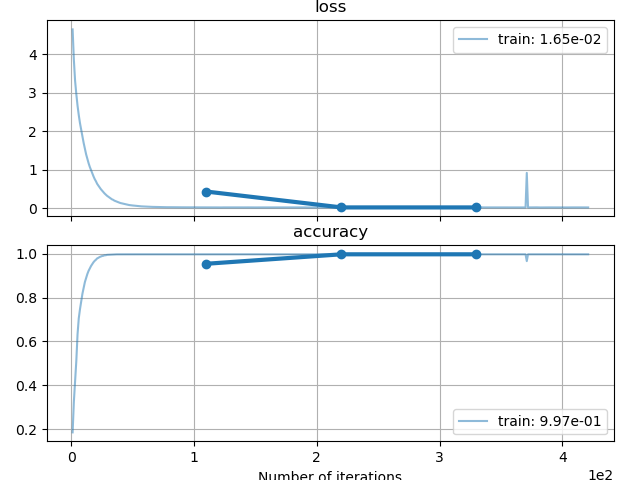

In [52]:
from noggin import create_plot
import matplotlib
%matplotlib notebook
plotter, fig, ax = create_plot(metrics=['loss', 'accuracy'], last_n_batches=1000)

In [53]:
def accuracy(predictions, truth):
    return np.mean((torch.argmax(predictions, dim=1) == truth).cpu().numpy())

In [54]:
batch_size = 64
epochs = 200

for e in range(epochs):
    index = np.arange(len(network_input))
    np.random.shuffle(index)
    
    loss = None
    for batch in range(0, len(network_input), batch_size):
        
        batch_indices = index[batch:batch+batch_size]
        x_train = network_input[batch_indices]
        y_train = network_output[batch_indices]
        #print(x_train[:50], y_train[:50])
        
        train_data = torch.tensor(x_train, dtype=torch.float32, device='cuda').to(device)
        test_data = torch.tensor(y_train, dtype=torch.long, device='cuda').to(device)
        
        y_pred = model(train_data)
        loss = nn.functional.cross_entropy(y_pred, test_data)
        acc = accuracy(y_pred, test_data)
        loss.backward()
        optim.step()
        
        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc}, batch_size=batch_size)
        
    plotter.set_train_epoch()
    
    
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            }, '././combined.tar')
    if e % 5 == 0:
        print("EPOCH: ", e)
plotter.plot()

[[[0.87179487]
  [0.65897436]
  [0.3974359 ]
  ...
  [0.44102564]
  [0.3974359 ]
  [0.87179487]]

 [[0.27692308]
  [0.81538462]
  [0.87179487]
  ...
  [0.81538462]
  [0.87179487]
  [0.76666667]]

 [[0.32307692]
  [0.27179487]
  [0.32307692]
  ...
  [0.66923077]
  [0.9025641 ]
  [0.85384615]]

 ...

 [[0.48974359]
  [0.63076923]
  [0.08974359]
  ...
  [0.9       ]
  [0.76666667]
  [0.72051282]]

 [[0.00512821]
  [0.84358974]
  [0.62307692]
  ...
  [0.87179487]
  [0.44871795]
  [0.3974359 ]]

 [[0.9025641 ]
  [0.62307692]
  [0.52307692]
  ...
  [0.53589744]
  [0.65128205]
  [0.85384615]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.38974359]
  [0.36410256]
  [0.3974359 ]
  ...
  [0.85384615]
  [0.37435897]
  [0.38974359]]

 [[0.3974359 ]
  [0.90512821]
  [0.87179487]
  ...
  [0.62820513]
  [0.87179487]
  [0.81538462]]

 [[0.56923077]
  [0.0025641 ]
  [0.37692308]
  ...
  [

 [0. 0. 0. ... 0. 0. 0.]]
[[[0.65897436]
  [0.93589744]
  [0.46923077]
  ...
  [0.65897436]
  [0.84358974]
  [0.68461538]]

 [[0.38205128]
  [0.52307692]
  [0.66923077]
  ...
  [0.9       ]
  [0.92051282]
  [0.        ]]

 [[0.65897436]
  [0.2025641 ]
  [0.37692308]
  ...
  [0.7974359 ]
  [0.3974359 ]
  [0.37692308]]

 ...

 [[0.53333333]
  [0.3974359 ]
  [0.87179487]
  ...
  [0.87179487]
  [0.81538462]
  [0.89487179]]

 [[0.61538462]
  [0.9025641 ]
  [0.51025641]
  ...
  [0.12564103]
  [0.75128205]
  [0.90769231]]

 [[0.85384615]
  [0.84358974]
  [0.91794872]
  ...
  [0.56666667]
  [0.53589744]
  [0.74102564]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.5974359 ]
  [0.83589744]
  [0.88717949]
  ...
  [0.97179487]
  [0.06666667]
  [0.06666667]]

 [[0.76666667]
  [0.72051282]
  [0.        ]
  ...
  [0.58717949]
  [0.27692308]
  [0.63076923]]

 [[0.52564103]
  [0.66923077

[[[0.26410256]
  [0.77692308]
  [0.82051282]
  ...
  [0.        ]
  [0.14358974]
  [0.2025641 ]]

 [[0.52307692]
  [0.46153846]
  [0.84358974]
  ...
  [0.84615385]
  [0.58717949]
  [0.46153846]]

 [[0.51025641]
  [0.5       ]
  [0.9       ]
  ...
  [0.84358974]
  [0.45897436]
  [0.56666667]]

 ...

 [[0.76410256]
  [0.44871795]
  [0.84358974]
  ...
  [0.12564103]
  [0.84358974]
  [0.12564103]]

 [[0.51025641]
  [0.72051282]
  [0.56666667]
  ...
  [0.87179487]
  [0.56666667]
  [0.46923077]]

 [[0.53589744]
  [0.65128205]
  [0.58717949]
  ...
  [0.87179487]
  [0.3974359 ]
  [0.87179487]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.57435897]
  [0.58717949]
  [0.9       ]
  ...
  [0.3974359 ]
  [0.9       ]
  [0.91794872]]

 [[0.9       ]
  [0.22820513]
  [0.75128205]
  ...
  [0.11538462]
  [0.74102564]
  [0.91794872]]

 [[0.65897436]
  [0.9025641 ]
  [0.46923077]
  ...
  [

[[[0.56666667]
  [0.5974359 ]
  [0.7974359 ]
  ...
  [0.54615385]
  [0.65897436]
  [0.9025641 ]]

 [[0.78974359]
  [0.83589744]
  [0.27692308]
  ...
  [0.58717949]
  [0.63076923]
  [0.76666667]]

 [[0.74102564]
  [0.44871795]
  [0.52307692]
  ...
  [0.34871795]
  [0.38974359]
  [0.9       ]]

 ...

 [[0.44102564]
  [0.56666667]
  [0.84358974]
  ...
  [0.87179487]
  [0.52307692]
  [0.3974359 ]]

 [[0.6       ]
  [0.75128205]
  [0.85384615]
  ...
  [0.5974359 ]
  [0.52564103]
  [0.75128205]]

 [[0.65897436]
  [0.2025641 ]
  [0.37692308]
  ...
  [0.56666667]
  [0.9       ]
  [0.65897436]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.54615385]
  [0.46923077]
  [0.54615385]
  ...
  [0.9       ]
  [0.82820513]
  [0.84358974]]

 [[0.9025641 ]
  [0.84615385]
  [0.9025641 ]
  ...
  [0.66923077]
  [0.72564103]
  [0.85384615]]

 [[0.84358974]
  [0.44871795]
  [0.9025641 ]
  ...
  [

[[[0.90512821]
  [0.87179487]
  [0.3974359 ]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.55384615]]

 [[0.58717949]
  [0.53589744]
  [0.90769231]
  ...
  [0.68205128]
  [0.53589744]
  [0.58717949]]

 [[0.57435897]
  [0.3974359 ]
  [0.87179487]
  ...
  [0.85384615]
  [0.3974359 ]
  [0.75128205]]

 ...

 [[0.83589744]
  [0.61538462]
  [0.60769231]
  ...
  [0.9025641 ]
  [0.56666667]
  [0.84358974]]

 [[0.56153846]
  [0.76666667]
  [0.56666667]
  ...
  [0.58717949]
  [0.83589744]
  [0.87179487]]

 [[0.84358974]
  [0.52307692]
  [0.75128205]
  ...
  [0.66923077]
  [0.65128205]
  [0.98461538]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.38205128]
  [0.3974359 ]
  [0.84358974]
  ...
  [0.6025641 ]
  [0.44871795]
  [0.87179487]]

 [[0.27692308]
  [0.95128205]
  [0.13076923]
  ...
  [0.88717949]
  [0.66923077]
  [0.9       ]]

 [[0.00512821]
  [0.65897436]
  [0.84358974]
  ...
  [

[[[0.3974359 ]
  [0.66923077]
  [0.87179487]
  ...
  [0.70512821]
  [0.0025641 ]
  [0.61538462]]

 [[0.84358974]
  [0.87179487]
  [0.38205128]
  ...
  [0.92307692]
  [0.3974359 ]
  [0.84358974]]

 [[0.75384615]
  [0.9025641 ]
  [0.9025641 ]
  ...
  [0.59230769]
  [0.74102564]
  [0.84358974]]

 ...

 [[0.83589744]
  [0.66923077]
  [0.65128205]
  ...
  [0.62307692]
  [0.61538462]
  [0.71282051]]

 [[0.84358974]
  [0.44871795]
  [0.14615385]
  ...
  [0.84358974]
  [0.44871795]
  [0.57435897]]

 [[0.84358974]
  [0.65897436]
  [0.5025641 ]
  ...
  [0.58717949]
  [0.9       ]
  [0.91794872]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.56666667]
  [0.9025641 ]
  [0.44102564]
  ...
  [0.84358974]
  [0.56666667]
  [0.44102564]]

 [[0.83589744]
  [0.91794872]
  [0.37435897]
  ...
  [0.41282051]
  [0.9       ]
  [0.37435897]]

 [[0.63076923]
  [0.27692308]
  [0.58717949]
  ...
  [

[[[0.51025641]
  [0.98461538]
  [0.46153846]
  ...
  [0.53589744]
  [0.51025641]
  [0.98461538]]

 [[0.75128205]
  [0.5       ]
  [0.53589744]
  ...
  [0.98461538]
  [0.53589744]
  [0.5       ]]

 [[0.50769231]
  [0.61282051]
  [0.7025641 ]
  ...
  [0.22820513]
  [0.97435897]
  [0.2025641 ]]

 ...

 [[0.28205128]
  [0.52307692]
  [0.65897436]
  ...
  [0.84358974]
  [0.62307692]
  [0.85384615]]

 [[0.66923077]
  [0.85384615]
  [0.9025641 ]
  ...
  [0.94615385]
  [0.46923077]
  [0.62307692]]

 [[0.9       ]
  [0.47692308]
  [0.51025641]
  ...
  [0.81538462]
  [0.87179487]
  [0.9       ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.85128205]
  [0.53589744]
  [0.48974359]
  ...
  [0.68205128]
  [0.58717949]
  [0.28717949]]

 [[0.52307692]
  [0.9025641 ]
  [0.57435897]
  ...
  [0.9025641 ]
  [0.66923077]
  [0.52307692]]

 [[0.85384615]
  [0.65897436]
  [0.53589744]
  ...
  [

[[[0.3974359 ]
  [0.66923077]
  [0.87179487]
  ...
  [0.87179487]
  [0.89487179]
  [0.67948718]]

 [[0.        ]
  [0.90512821]
  [0.90512821]
  ...
  [0.27179487]
  [0.32307692]
  [0.17692308]]

 [[0.56666667]
  [0.85384615]
  [0.84358974]
  ...
  [0.68205128]
  [0.65897436]
  [0.53589744]]

 ...

 [[0.62307692]
  [0.53589744]
  [0.03333333]
  ...
  [0.51025641]
  [0.9       ]
  [0.82820513]]

 [[0.42820513]
  [0.63846154]
  [0.29230769]
  ...
  [0.17692308]
  [0.46923077]
  [0.72051282]]

 [[0.03846154]
  [0.44871795]
  [0.52307692]
  ...
  [0.9       ]
  [0.9       ]
  [0.28461538]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.7974359 ]
  [0.54615385]
  [0.65897436]
  ...
  [0.56666667]
  [0.37692308]
  [0.5974359 ]]

 [[0.11538462]
  [0.15384615]
  [0.        ]
  ...
  [0.3974359 ]
  [0.5       ]
  [0.87179487]]

 [[0.04615385]
  [0.72051282]
  [0.87179487]
  ...
  [

[[[0.66923077]
  [0.57435897]
  [0.52307692]
  ...
  [0.84358974]
  [0.66923077]
  [0.85384615]]

 [[0.9       ]
  [0.57435897]
  [0.84358974]
  ...
  [0.54615385]
  [0.38205128]
  [0.46923077]]

 [[0.3974359 ]
  [0.66923077]
  [0.87179487]
  ...
  [0.52307692]
  [0.87179487]
  [0.57435897]]

 ...

 [[0.98461538]
  [0.53589744]
  [0.5       ]
  ...
  [0.51025641]
  [0.98461538]
  [0.46153846]]

 [[0.68461538]
  [0.67179487]
  [0.9025641 ]
  ...
  [0.44871795]
  [0.57435897]
  [0.85897436]]

 [[0.9       ]
  [0.9       ]
  [0.41282051]
  ...
  [0.98461538]
  [0.14358974]
  [0.74102564]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.30512821]
  [0.32051282]
  [0.33076923]
  ...
  [0.9025641 ]
  [0.18205128]
  [0.61025641]]

 [[0.42307692]
  [0.58717949]
  [0.9025641 ]
  ...
  [0.72051282]
  [0.9       ]
  [0.47948718]]

 [[0.3974359 ]
  [0.36410256]
  [0.38974359]
  ...
  [

[[[0.44102564]
  [0.84358974]
  [0.83589744]
  ...
  [0.51025641]
  [0.9       ]
  [0.70769231]]

 [[0.34871795]
  [0.27692308]
  [0.22820513]
  ...
  [0.73076923]
  [0.53589744]
  [0.65128205]]

 [[0.03846154]
  [0.44871795]
  [0.52307692]
  ...
  [0.9       ]
  [0.9       ]
  [0.28461538]]

 ...

 [[0.52307692]
  [0.9025641 ]
  [0.66923077]
  ...
  [0.9       ]
  [0.92051282]
  [0.34871795]]

 [[0.48974359]
  [0.80512821]
  [0.53589744]
  ...
  [0.53589744]
  [0.24615385]
  [0.58717949]]

 [[0.09230769]
  [0.21025641]
  [0.24871795]
  ...
  [0.41538462]
  [0.23846154]
  [0.57692308]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.52307692]
  [0.66923077]
  [0.87435897]
  ...
  [0.57435897]
  [0.85384615]
  [0.84358974]]

 [[0.81538462]
  [0.42820513]
  [0.        ]
  ...
  [0.9       ]
  [0.51025641]
  [0.47692308]]

 [[0.18461538]
  [0.42820513]
  [0.3974359 ]
  ...
  [

[[[0.63846154]
  [0.5974359 ]
  [0.54615385]
  ...
  [0.56666667]
  [0.44871795]
  [0.44102564]]

 [[0.87179487]
  [0.6974359 ]
  [0.57435897]
  ...
  [0.87179487]
  [0.66923077]
  [0.3974359 ]]

 [[0.9       ]
  [0.65897436]
  [0.35384615]
  ...
  [0.46923077]
  [0.7974359 ]
  [0.3974359 ]]

 ...

 [[0.3974359 ]
  [0.87179487]
  [0.3974359 ]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.53333333]]

 [[0.42820513]
  [0.49487179]
  [0.77948718]
  ...
  [0.9       ]
  [0.18461538]
  [0.42820513]]

 [[0.3974359 ]
  [0.38205128]
  [0.91794872]
  ...
  [0.91282051]
  [0.13846154]
  [0.91282051]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.22820513]
  [0.97435897]
  [0.2025641 ]
  ...
  [0.3974359 ]
  [0.66923077]
  [0.87179487]]

 [[0.66923077]
  [0.87435897]
  [0.65897436]
  ...
  [0.85384615]
  [0.84358974]
  [0.44871795]]

 [[0.22564103]
  [0.38974359]
  [0.9       ]
  ...
  [

[[[0.3974359 ]
  [0.38974359]
  [0.9       ]
  ...
  [0.66923077]
  [0.52307692]
  [0.65128205]]

 [[0.3974359 ]
  [0.52307692]
  [0.87179487]
  ...
  [0.83846154]
  [0.01794872]
  [0.31282051]]

 [[0.83589744]
  [0.91794872]
  [0.58717949]
  ...
  [0.3974359 ]
  [0.38205128]
  [0.91794872]]

 ...

 [[0.84358974]
  [0.44871795]
  [0.74102564]
  ...
  [0.3974359 ]
  [0.53589744]
  [0.87179487]]

 [[0.84358974]
  [0.28205128]
  [0.52307692]
  ...
  [0.00512821]
  [0.84358974]
  [0.66923077]]

 [[0.81538462]
  [0.87179487]
  [0.58205128]
  ...
  [0.63076923]
  [0.80512821]
  [0.76666667]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.66923077]
  [0.9       ]
  [0.85384615]
  ...
  [0.52564103]
  [0.66923077]
  [0.72564103]]

 [[0.12564103]
  [0.84358974]
  [0.12564103]
  ...
  [0.83589744]
  [0.5       ]
  [0.83589744]]

 [[0.38205128]
  [0.68205128]
  [0.7974359 ]
  ...
  [

[[[0.75128205]
  [0.9       ]
  [0.9       ]
  ...
  [0.98461538]
  [0.        ]
  [0.51025641]]

 [[0.91794872]
  [0.52307692]
  [0.7       ]
  ...
  [0.74102564]
  [0.91794872]
  [0.57435897]]

 [[0.87179487]
  [0.63076923]
  [0.53589744]
  ...
  [0.61538462]
  [0.9025641 ]
  [0.51025641]]

 ...

 [[0.57435897]
  [0.3974359 ]
  [0.66923077]
  ...
  [0.52307692]
  [0.70512821]
  [0.0025641 ]]

 [[0.98461538]
  [0.3974359 ]
  [0.88974359]
  ...
  [0.9       ]
  [0.9       ]
  [0.        ]]

 [[0.44871795]
  [0.0025641 ]
  [0.52307692]
  ...
  [0.00512821]
  [0.84358974]
  [0.66923077]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.9       ]
  [0.47692308]
  [0.98461538]
  ...
  [0.87179487]
  [0.9       ]
  [0.81538462]]

 [[0.87179487]
  [0.72051282]
  [0.9       ]
  ...
  [0.65897436]
  [0.98461538]
  [0.22820513]]

 [[0.44871795]
  [0.52307692]
  [0.9025641 ]
  ...
  [

[[[0.9       ]
  [0.68717949]
  [0.84358974]
  ...
  [0.44871795]
  [0.57435897]
  [0.9       ]]

 [[0.95128205]
  [0.81538462]
  [0.62820513]
  ...
  [0.76666667]
  [0.68205128]
  [0.76666667]]

 [[0.44871795]
  [0.84358974]
  [0.38205128]
  ...
  [0.52307692]
  [0.85384615]
  [0.52307692]]

 ...

 [[0.95641026]
  [0.3974359 ]
  [0.8974359 ]
  ...
  [0.9       ]
  [0.        ]
  [0.52307692]]

 [[0.68205128]
  [0.87179487]
  [0.76666667]
  ...
  [0.23589744]
  [0.56666667]
  [0.84358974]]

 [[0.87179487]
  [0.74102564]
  [0.3974359 ]
  ...
  [0.6974359 ]
  [0.83589744]
  [0.87179487]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.61025641]
  [0.43333333]
  [0.9025641 ]
  ...
  [0.77692308]
  [0.92051282]
  [0.78717949]]

 [[0.9       ]
  [0.38974359]
  [0.38205128]
  ...
  [0.67179487]
  [0.11794872]
  [0.57692308]]

 [[0.98461538]
  [0.46923077]
  [0.83589744]
  ...
  [

[[[0.98461538]
  [0.75128205]
  [0.5       ]
  ...
  [0.51025641]
  [0.98461538]
  [0.53589744]]

 [[0.9025641 ]
  [0.53589744]
  [0.58717949]
  ...
  [0.90769231]
  [0.90769231]
  [0.74358974]]

 [[0.65897436]
  [0.84358974]
  [0.28205128]
  ...
  [0.52307692]
  [0.00512821]
  [0.84358974]]

 ...

 [[0.72564103]
  [0.49487179]
  [0.42820513]
  ...
  [0.42820513]
  [0.9       ]
  [0.18717949]]

 [[0.56666667]
  [0.98461538]
  [0.46923077]
  ...
  [0.46923077]
  [0.44102564]
  [0.98461538]]

 [[0.44871795]
  [0.57435897]
  [0.85384615]
  ...
  [0.85384615]
  [0.44871795]
  [0.57435897]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.3974359 ]
  [0.87179487]
  [0.38205128]
  ...
  [0.38205128]
  [0.52307692]
  [0.66923077]]

 [[0.52307692]
  [0.65128205]
  [0.44871795]
  ...
  [0.44102564]
  [0.9       ]
  [0.65897436]]

 [[0.38205128]
  [0.3974359 ]
  [0.87179487]
  ...
  [

[[[0.3974359 ]
  [0.87179487]
  [0.46923077]
  ...
  [0.44102564]
  [0.56666667]
  [0.9025641 ]]

 [[0.9       ]
  [0.86153846]
  [0.87692308]
  ...
  [0.42307692]
  [0.46153846]
  [0.12307692]]

 [[0.66923077]
  [0.69487179]
  [0.85384615]
  ...
  [0.38205128]
  [0.87179487]
  [0.44871795]]

 ...

 [[0.46923077]
  [0.56666667]
  [0.37692308]
  ...
  [0.9025641 ]
  [0.23589744]
  [0.75897436]]

 [[0.87179487]
  [0.44871795]
  [0.3974359 ]
  ...
  [0.87179487]
  [0.57435897]
  [0.3974359 ]]

 [[0.7974359 ]
  [0.2025641 ]
  [0.41794872]
  ...
  [0.58717949]
  [0.68205128]
  [0.9       ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.11538462]
  [0.46153846]
  [0.46923077]
  ...
  [0.3974359 ]
  [0.38974359]
  [0.9       ]]

 [[0.66923077]
  [0.88205128]
  [0.65897436]
  ...
  [0.68717949]
  [0.84358974]
  [0.52307692]]

 [[0.89487179]
  [0.67948718]
  [0.3974359 ]
  ...
  [

[[[0.6025641 ]
  [0.44871795]
  [0.87179487]
  ...
  [0.87179487]
  [0.52307692]
  [0.3974359 ]]

 [[0.68461538]
  [0.52307692]
  [0.9       ]
  ...
  [0.85384615]
  [0.9       ]
  [0.46410256]]

 [[0.90769231]
  [0.0025641 ]
  [0.87179487]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.56153846]]

 ...

 [[0.72564103]
  [0.19230769]
  [0.77948718]
  ...
  [0.58717949]
  [0.46153846]
  [0.85384615]]

 [[0.66923077]
  [0.69487179]
  [0.85384615]
  ...
  [0.7974359 ]
  [0.53589744]
  [0.38205128]]

 [[0.58717949]
  [0.27692308]
  [0.63076923]
  ...
  [0.9025641 ]
  [0.63076923]
  [0.58717949]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[[0.35897436]
  [0.76666667]
  [0.3974359 ]
  ...
  [0.9025641 ]
  [0.81538462]
  [0.49487179]]

 [[0.11794872]
  [0.84615385]
  [0.35128205]
  ...
  [0.88461538]
  [0.9025641 ]
  [0.69230769]]

 [[0.57435897]
  [0.85384615]
  [0.57435897]
  ...
  [

 [0. 0. 0. ... 0. 0. 0.]]
[[[0.9025641 ]
  [0.23589744]
  [0.75897436]
  ...
  [0.84358974]
  [0.44871795]
  [0.57435897]]

 [[0.48974359]
  [0.87948718]
  [0.42051282]
  ...
  [0.58717949]
  [0.53589744]
  [0.26923077]]

 [[0.86410256]
  [0.4974359 ]
  [0.65384615]
  ...
  [0.76153846]
  [0.9025641 ]
  [0.81282051]]

 ...

 [[0.7974359 ]
  [0.54615385]
  [0.37692308]
  ...
  [0.51025641]
  [0.54615385]
  [0.38205128]]

 [[0.76666667]
  [0.63076923]
  [0.53333333]
  ...
  [0.48974359]
  [0.80512821]
  [0.53589744]]

 [[0.5974359 ]
  [0.63846154]
  [0.72564103]
  ...
  [0.63846154]
  [0.51538462]
  [0.54615385]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.87435897]
  [0.75128205]
  [0.85384615]
  ...
  [0.49487179]
  [0.85384615]
  [0.5974359 ]]

 [[0.42564103]
  [0.22307692]
  [0.86410256]
  ...
  [0.54358974]
  [0.33589744]
  [0.63589744]]

 [[0.51538462]
  [0.5974359 

 [0. 0. 0. ... 0. 0. 0.]]
[[[0.56666667]
  [0.46923077]
  [0.84358974]
  ...
  [0.27692308]
  [0.95128205]
  [0.13076923]]

 [[0.87948718]
  [0.84358974]
  [0.52307692]
  ...
  [0.87179487]
  [0.38205128]
  [0.44871795]]

 [[0.76153846]
  [0.3974359 ]
  [0.9       ]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.38717949]]

 ...

 [[0.88717949]
  [0.77948718]
  [0.40769231]
  ...
  [0.95128205]
  [0.38205128]
  [0.84358974]]

 [[0.6974359 ]
  [0.83589744]
  [0.87179487]
  ...
  [0.84358974]
  [0.0025641 ]
  [0.65897436]]

 [[0.83589744]
  [0.5       ]
  [0.83589744]
  ...
  [0.84358974]
  [0.44871795]
  [0.14615385]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.90769231]
  [0.27692308]
  [0.95128205]
  ...
  [0.66923077]
  [0.69487179]
  [0.85384615]]

 [[0.14358974]
  [0.57435897]
  [0.58717949]
  ...
  [0.9       ]
  [0.92051282]
  [0.        ]]

 [[0.65897436]
  [0.2025641 

[[[0.51025641]
  [0.91794872]
  [0.52307692]
  ...
  [0.85384615]
  [0.84358974]
  [0.91794872]]

 [[0.5974359 ]
  [0.87179487]
  [0.54615385]
  ...
  [0.77948718]
  [0.12307692]
  [0.69487179]]

 [[0.14871795]
  [0.84358974]
  [0.44871795]
  ...
  [0.87179487]
  [0.74102564]
  [0.3974359 ]]

 ...

 [[0.3974359 ]
  [0.87179487]
  [0.8974359 ]
  ...
  [0.3974359 ]
  [0.6974359 ]
  [0.87179487]]

 [[0.65897436]
  [0.66923077]
  [0.65897436]
  ...
  [0.22564103]
  [0.3974359 ]
  [0.38974359]]

 [[0.24871795]
  [0.25897436]
  [0.90769231]
  ...
  [0.57692308]
  [0.9025641 ]
  [0.48461538]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.9       ]
  [0.9       ]
  [0.73076923]
  ...
  [0.90512821]
  [0.22820513]
  [0.74358974]]

 [[0.84358974]
  [0.57435897]
  [0.85384615]
  ...
  [0.87179487]
  [0.84358974]
  [0.3974359 ]]

 [[0.51025641]
  [0.91794872]
  [0.44102564]
  ...
  [

[[[0.83846154]
  [0.23076923]
  [0.16666667]
  ...
  [0.9025641 ]
  [0.53333333]
  [0.92051282]]

 [[0.0025641 ]
  [0.65897436]
  [0.84358974]
  ...
  [0.74102564]
  [0.44871795]
  [0.52307692]]

 [[0.44871795]
  [0.85384615]
  [0.9       ]
  ...
  [0.77948718]
  [0.69487179]
  [0.88717949]]

 ...

 [[0.84358974]
  [0.9025641 ]
  [0.52307692]
  ...
  [0.58974359]
  [0.85384615]
  [0.9       ]]

 [[0.41282051]
  [0.17435897]
  [0.9       ]
  ...
  [0.74102564]
  [0.9       ]
  [0.84358974]]

 [[0.44871795]
  [0.98461538]
  [0.3974359 ]
  ...
  [0.84358974]
  [0.87179487]
  [0.38205128]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.98461538]
  [0.3974359 ]
  [0.83589744]
  ...
  [0.51025641]
  [0.98461538]
  [0.5974359 ]]

 [[0.65897436]
  [0.84358974]
  [0.51025641]
  ...
  [0.56666667]
  [0.9025641 ]
  [0.84358974]]

 [[0.52307692]
  [0.9       ]
  [0.9       ]
  ...
  [

[[[0.81538462]
  [0.54871795]
  [0.62820513]
  ...
  [0.68205128]
  [0.42051282]
  [0.76666667]]

 [[0.84358974]
  [0.44871795]
  [0.57435897]
  ...
  [0.52307692]
  [0.65897436]
  [0.84358974]]

 [[0.66923077]
  [0.9       ]
  [0.9       ]
  ...
  [0.98461538]
  [0.34871795]
  [0.51025641]]

 ...

 [[0.61025641]
  [0.43333333]
  [0.9025641 ]
  ...
  [0.77692308]
  [0.92051282]
  [0.78717949]]

 [[0.70512821]
  [0.52307692]
  [0.9025641 ]
  ...
  [0.91794872]
  [0.52307692]
  [0.83589744]]

 [[0.87179487]
  [0.84358974]
  [0.3974359 ]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.65897436]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.69487179]
  [0.5974359 ]
  [0.77948718]
  ...
  [0.44871795]
  [0.0025641 ]
  [0.52307692]]

 [[0.61538462]
  [0.91794872]
  [0.74102564]
  ...
  [0.78974359]
  [0.9       ]
  [0.41282051]]

 [[0.46923077]
  [0.3974359 ]
  [0.54615385]
  ...
  [

[[[0.98205128]
  [0.62820513]
  [0.71794872]
  ...
  [0.2025641 ]
  [0.14358974]
  [0.        ]]

 [[0.59230769]
  [0.84358974]
  [0.44871795]
  ...
  [0.69487179]
  [0.5974359 ]
  [0.77948718]]

 [[0.52307692]
  [0.76666667]
  [0.38205128]
  ...
  [0.63589744]
  [0.82051282]
  [0.55897436]]

 ...

 [[0.85384615]
  [0.54871795]
  [0.66923077]
  ...
  [0.54615385]
  [0.66923077]
  [0.94615385]]

 [[0.68205128]
  [0.92307692]
  [0.14358974]
  ...
  [0.92307692]
  [0.34871795]
  [0.38974359]]

 [[0.3974359 ]
  [0.87179487]
  [0.56666667]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.65897436]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.3974359 ]
  [0.87179487]
  [0.3974359 ]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.58205128]]

 [[0.51025641]
  [0.53589744]
  [0.65897436]
  ...
  [0.3974359 ]
  [0.56666667]
  [0.76666667]]

 [[0.9025641 ]
  [0.85384615]
  [0.66923077]
  ...
  [

[[[0.12820513]
  [0.27692308]
  [0.34871795]
  ...
  [0.3974359 ]
  [0.43589744]
  [0.87179487]]

 [[0.62307692]
  [0.52307692]
  [0.3974359 ]
  ...
  [0.98461538]
  [0.3974359 ]
  [0.88974359]]

 [[0.46923077]
  [0.83589744]
  [0.5974359 ]
  ...
  [0.98461538]
  [0.5974359 ]
  [0.83589744]]

 ...

 [[0.75128205]
  [0.91794872]
  [0.3974359 ]
  ...
  [0.52307692]
  [0.9025641 ]
  [0.66923077]]

 [[0.44871795]
  [0.95128205]
  [0.38205128]
  ...
  [0.85384615]
  [0.66923077]
  [0.12051282]]

 [[0.98461538]
  [0.3974359 ]
  [0.88974359]
  ...
  [0.38205128]
  [0.44871795]
  [0.98461538]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.53589744]
  [0.90769231]
  [0.58717949]
  ...
  [0.53589744]
  [0.58717949]
  [0.46153846]]

 [[0.66666667]
  [0.53589744]
  [0.90512821]
  ...
  [0.68205128]
  [0.58717949]
  [0.68205128]]

 [[0.68205128]
  [0.51025641]
  [0.53589744]
  ...
  [

[[[0.14358974]
  [0.74102564]
  [0.9       ]
  ...
  [0.73076923]
  [0.1974359 ]
  [0.60769231]]

 [[0.53589744]
  [0.58717949]
  [0.46153846]
  ...
  [0.53589744]
  [0.68205128]
  [0.57435897]]

 [[0.20769231]
  [0.84358974]
  [0.52307692]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.74102564]]

 ...

 [[0.87179487]
  [0.83589744]
  [0.3974359 ]
  ...
  [0.87179487]
  [0.3974359 ]
  [0.97179487]]

 [[0.71794872]
  [0.02564103]
  [0.62820513]
  ...
  [0.39487179]
  [0.54358974]
  [0.63589744]]

 [[0.72564103]
  [0.85384615]
  [0.88717949]
  ...
  [0.74102564]
  [0.48974359]
  [0.65897436]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.12307692]
  [0.46923077]
  [0.54871795]
  ...
  [0.04102564]
  [0.90512821]
  [0.90512821]]

 [[0.66923077]
  [0.87435897]
  [0.65897436]
  ...
  [0.85384615]
  [0.84358974]
  [0.44871795]]

 [[0.57435897]
  [0.52307692]
  [0.74102564]
  ...
  [

[[[0.9       ]
  [0.58717949]
  [0.46153846]
  ...
  [0.65897436]
  [0.2025641 ]
  [0.37692308]]

 [[0.53589744]
  [0.58717949]
  [0.46153846]
  ...
  [0.68205128]
  [0.58717949]
  [0.24358974]]

 [[0.00512821]
  [0.84358974]
  [0.62307692]
  ...
  [0.87179487]
  [0.44871795]
  [0.3974359 ]]

 ...

 [[0.3025641 ]
  [0.2974359 ]
  [0.9025641 ]
  ...
  [0.87435897]
  [0.75128205]
  [0.85384615]]

 [[0.87179487]
  [0.81538462]
  [0.61794872]
  ...
  [0.73846154]
  [0.87179487]
  [0.76666667]]

 [[0.14358974]
  [0.73076923]
  [0.9       ]
  ...
  [0.27692308]
  [0.81538462]
  [0.87179487]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.3974359 ]
  [0.38974359]
  [0.26666667]
  ...
  [0.56153846]
  [0.38205128]
  [0.37435897]]

 [[0.63076923]
  [0.76666667]
  [0.87179487]
  ...
  [0.90769231]
  [0.00512821]
  [0.00512821]]

 [[0.75128205]
  [0.66923077]
  [0.57435897]
  ...
  [

  [0.9       ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.55641026]
  [0.53333333]
  [0.53589744]
  ...
  [0.53589744]
  [0.48974359]
  [0.85128205]]

 [[0.3974359 ]
  [0.84358974]
  [0.87179487]
  ...
  [0.9025641 ]
  [0.57435897]
  [0.52307692]]

 [[0.57435897]
  [0.85384615]
  [0.76923077]
  ...
  [0.59230769]
  [0.84358974]
  [0.44871795]]

 ...

 [[0.5       ]
  [0.53589744]
  [0.65128205]
  ...
  [0.53589744]
  [0.5       ]
  [0.63076923]]

 [[0.9       ]
  [0.58717949]
  [0.63076923]
  ...
  [0.56153846]
  [0.9       ]
  [0.65128205]]

 [[0.61538462]
  [0.51025641]
  [0.9       ]
  ...
  [0.44871795]
  [0.84358974]
  [0.44871795]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.56666667]
  [0.98461538]
  [0.3974359 ]
  ...
  [0.3974359 ]
  [0.510256

[[[0.12564103]
  [0.75128205]
  [0.90769231]
  ...
  [0.83589744]
  [0.51025641]
  [0.65897436]]

 [[0.62307692]
  [0.85384615]
  [0.62307692]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.38205128]]

 [[0.85384615]
  [0.9       ]
  [0.63333333]
  ...
  [0.53589744]
  [0.38974359]
  [0.46153846]]

 ...

 [[0.46153846]
  [0.84358974]
  [0.42307692]
  ...
  [0.58717949]
  [0.46153846]
  [0.9       ]]

 [[0.42820513]
  [0.14358974]
  [0.81538462]
  ...
  [0.74102564]
  [0.9       ]
  [0.84358974]]

 [[0.75128205]
  [0.77179487]
  [0.12564103]
  ...
  [0.12564103]
  [0.03589744]
  [0.        ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.9       ]
  [0.9       ]
  [0.22820513]
  ...
  [0.34871795]
  [0.51025641]
  [0.9       ]]

 [[0.48205128]
  [0.57435897]
  [0.24102564]
  ...
  [0.21282051]
  [0.9       ]
  [0.9       ]]

 [[0.87179487]
  [0.53333333]
  [0.3974359 ]
  ...
  [

[[[0.66923077]
  [0.65128205]
  [0.98461538]
  ...
  [0.56666667]
  [0.75128205]
  [0.51025641]]

 [[0.46153846]
  [0.68205128]
  [0.53589744]
  ...
  [0.04615385]
  [0.72564103]
  [0.88717949]]

 [[0.87179487]
  [0.95128205]
  [0.81538462]
  ...
  [0.99487179]
  [0.76666667]
  [0.68205128]]

 ...

 [[0.3974359 ]
  [0.76666667]
  [0.68205128]
  ...
  [0.84358974]
  [0.44871795]
  [0.23589744]]

 [[0.84615385]
  [0.27692308]
  [0.66153846]
  ...
  [0.67948718]
  [0.99230769]
  [0.47435897]]

 [[0.5974359 ]
  [0.9025641 ]
  [0.54615385]
  ...
  [0.84358974]
  [0.85384615]
  [0.27692308]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.3974359 ]
  [0.38205128]
  [0.46923077]
  ...
  [0.73589744]
  [0.14615385]
  [0.56410256]]

 [[0.87179487]
  [0.94358974]
  [0.82564103]
  ...
  [0.68205128]
  [0.87179487]
  [0.76923077]]

 [[0.84358974]
  [0.12564103]
  [0.75128205]
  ...
  [

[[[0.38205128]
  [0.2025641 ]
  [0.37692308]
  ...
  [0.38205128]
  [0.46923077]
  [0.56666667]]

 [[0.77435897]
  [0.84358974]
  [0.44871795]
  ...
  [0.38974359]
  [0.71282051]
  [0.85384615]]

 [[0.97179487]
  [0.87179487]
  [0.3974359 ]
  ...
  [0.3974359 ]
  [0.91282051]
  [0.87179487]]

 ...

 [[0.48205128]
  [0.57435897]
  [0.05128205]
  ...
  [0.03589744]
  [0.9       ]
  [0.9       ]]

 [[0.52307692]
  [0.9025641 ]
  [0.57435897]
  ...
  [0.9025641 ]
  [0.66923077]
  [0.52307692]]

 [[0.74871795]
  [0.95384615]
  [0.45641026]
  ...
  [0.97435897]
  [0.2025641 ]
  [0.14358974]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[[0.3974359 ]
  [0.87179487]
  [0.65897436]
  ...
  [0.84358974]
  [0.52307692]
  [0.57435897]]

 [[0.76666667]
  [0.3974359 ]
  [0.15384615]
  ...
  [0.76666667]
  [0.68205128]
  [0.9025641 ]]

 [[0.53589744]
  [0.65128205]
  [0.85384615]
  ...
  [

[[[0.87179487]
  [0.3974359 ]
  [0.87179487]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.53333333]]

 [[0.9025641 ]
  [0.75128205]
  [0.91794872]
  ...
  [0.3974359 ]
  [0.66923077]
  [0.87179487]]

 [[0.51025641]
  [0.91794872]
  [0.52307692]
  ...
  [0.85384615]
  [0.84358974]
  [0.91794872]]

 ...

 [[0.27435897]
  [0.76666667]
  [0.87179487]
  ...
  [0.58717949]
  [0.63076923]
  [0.76666667]]

 [[0.        ]
  [0.57435897]
  [0.66923077]
  ...
  [0.63076923]
  [0.27692308]
  [0.76666667]]

 [[0.44102564]
  [0.71282051]
  [0.37435897]
  ...
  [0.3974359 ]
  [0.68205128]
  [0.87179487]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.22820513]
  [0.97435897]
  [0.2025641 ]
  ...
  [0.3974359 ]
  [0.66923077]
  [0.87179487]]

 [[0.65128205]
  [0.52307692]
  [0.65897436]
  ...
  [0.9       ]
  [0.65897436]
  [0.2025641 ]]

 [[0.9025641 ]
  [0.75128205]
  [0.91794872]
  ...
  [

[[[0.52307692]
  [0.9       ]
  [0.38974359]
  ...
  [0.41794872]
  [0.52307692]
  [0.76923077]]

 [[0.58205128]
  [0.3974359 ]
  [0.87179487]
  ...
  [0.54871795]
  [0.62820513]
  [0.87179487]]

 [[0.38974359]
  [0.38461538]
  [0.68205128]
  ...
  [0.14358974]
  [0.20512821]
  [0.52564103]]

 ...

 [[0.12307692]
  [0.57435897]
  [0.46153846]
  ...
  [0.21282051]
  [0.9       ]
  [0.9       ]]

 [[0.49487179]
  [0.5974359 ]
  [0.12307692]
  ...
  [0.21538462]
  [0.9025641 ]
  [0.9025641 ]]

 [[0.83589744]
  [0.5974359 ]
  [0.51025641]
  ...
  [0.5974359 ]
  [0.83589744]
  [0.88717949]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.26666667]
  [0.3974359 ]
  [0.38974359]
  ...
  [0.37435897]
  [0.38974359]
  [0.38205128]]

 [[0.9       ]
  [0.58717949]
  [0.46153846]
  ...
  [0.65897436]
  [0.2025641 ]
  [0.37692308]]

 [[0.65897436]
  [0.84358974]
  [0.68461538]
  ...
  [

[[[0.66923077]
  [0.85384615]
  [0.9       ]
  ...
  [0.87948718]
  [0.84358974]
  [0.44871795]]

 [[0.53589744]
  [0.74102564]
  [0.38974359]
  ...
  [0.51025641]
  [0.53589744]
  [0.65897436]]

 [[0.3974359 ]
  [0.87179487]
  [0.57435897]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.85384615]]

 ...

 [[0.84358974]
  [0.44871795]
  [0.57435897]
  ...
  [0.9       ]
  [0.54102564]
  [0.84358974]]

 [[0.58717949]
  [0.9       ]
  [0.61794872]
  ...
  [0.54615385]
  [0.51538462]
  [0.5974359 ]]

 [[0.38205128]
  [0.3974359 ]
  [0.87179487]
  ...
  [0.90512821]
  [0.74102564]
  [0.3974359 ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.84358974]
  [0.3974359 ]
  [0.74102564]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.84358974]]

 [[0.53589744]
  [0.48974359]
  [0.80512821]
  ...
  [0.53589744]
  [0.26923077]
  [0.58717949]]

 [[0.66923077]
  [0.3974359 ]
  [0.87179487]
  ...
  [

[[[0.57435897]
  [0.3974359 ]
  [0.66923077]
  ...
  [0.3974359 ]
  [0.87179487]
  [0.89487179]]

 [[0.87179487]
  [0.74102564]
  [0.92307692]
  ...
  [0.65897436]
  [0.84358974]
  [0.52307692]]

 [[0.27692308]
  [0.12564103]
  [0.84358974]
  ...
  [0.65897436]
  [0.27692308]
  [0.84358974]]

 ...

 [[0.87179487]
  [0.85384615]
  [0.3974359 ]
  ...
  [0.38974359]
  [0.3974359 ]
  [0.87179487]]

 [[0.41282051]
  [0.78974359]
  [0.32564103]
  ...
  [0.81538462]
  [0.22820513]
  [0.42820513]]

 [[0.58717949]
  [0.46153846]
  [0.68205128]
  ...
  [0.57435897]
  [0.05128205]
  [0.84358974]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.52307692]
  [0.83589744]
  [0.66923077]
  ...
  [0.91794872]
  [0.75128205]
  [0.74102564]]

 [[0.54615385]
  [0.92307692]
  [0.14358974]
  ...
  [0.76666667]
  [0.36410256]
  [0.68205128]]

 [[0.56666667]
  [0.75128205]
  [0.74102564]
  ...
  [

[[[0.9025641 ]
  [0.52307692]
  [0.66923077]
  ...
  [0.85384615]
  [0.9       ]
  [0.63333333]]

 [[0.3974359 ]
  [0.37692308]
  [0.51025641]
  ...
  [0.38461538]
  [0.91282051]
  [0.91282051]]

 [[0.9025641 ]
  [0.68974359]
  [0.67692308]
  ...
  [0.74102564]
  [0.84358974]
  [0.44871795]]

 ...

 [[0.3974359 ]
  [0.6974359 ]
  [0.83589744]
  ...
  [0.52307692]
  [0.84358974]
  [0.0025641 ]]

 [[0.0025641 ]
  [0.65897436]
  [0.84358974]
  ...
  [0.70512821]
  [0.52307692]
  [0.66923077]]

 [[0.92051282]
  [0.        ]
  [0.53589744]
  ...
  [0.37435897]
  [0.38974359]
  [0.73076923]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.41794872]
  [0.53589744]
  [0.52307692]
  ...
  [0.33589744]
  [0.54358974]
  [0.63589744]]

 [[0.95128205]
  [0.2974359 ]
  [0.9025641 ]
  ...
  [0.6       ]
  [0.75128205]
  [0.85384615]]

 [[0.84358974]
  [0.44871795]
  [0.58461538]
  ...
  [

[[[0.52307692]
  [0.84358974]
  [0.65897436]
  ...
  [0.98461538]
  [0.85384615]
  [0.5       ]]

 [[0.5       ]
  [0.53589744]
  [0.65128205]
  ...
  [0.46153846]
  [0.5       ]
  [0.58717949]]

 [[0.53589744]
  [0.58717949]
  [0.53589744]
  ...
  [0.53589744]
  [0.58717949]
  [0.46153846]]

 ...

 [[0.87179487]
  [0.52307692]
  [0.3974359 ]
  ...
  [0.53589744]
  [0.9       ]
  [0.9       ]]

 [[0.66923077]
  [0.51025641]
  [0.91794872]
  ...
  [0.61538462]
  [0.71282051]
  [0.70512821]]

 [[0.76666667]
  [0.63076923]
  [0.58717949]
  ...
  [0.9       ]
  [0.22820513]
  [0.5       ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.5025641 ]
  [0.65897436]
  [0.84358974]
  ...
  [0.85384615]
  [0.77435897]
  [0.84358974]]

 [[0.52307692]
  [0.3974359 ]
  [0.87179487]
  ...
  [0.38974359]
  [0.75128205]
  [0.52307692]]

 [[0.13846154]
  [0.91282051]
  [0.16410256]
  ...
  [

[[[0.73076923]
  [0.9       ]
  [0.78974359]
  ...
  [0.17435897]
  [0.41282051]
  [0.91794872]]

 [[0.76153846]
  [0.9025641 ]
  [0.42564103]
  ...
  [0.27692308]
  [0.22820513]
  [0.2025641 ]]

 [[0.94871795]
  [0.3974359 ]
  [0.8974359 ]
  ...
  [0.87179487]
  [0.38974359]
  [0.46153846]]

 ...

 [[0.57435897]
  [0.84358974]
  [0.44871795]
  ...
  [0.84358974]
  [0.87179487]
  [0.38205128]]

 [[0.84358974]
  [0.56666667]
  [0.9025641 ]
  ...
  [0.56666667]
  [0.84358974]
  [0.56666667]]

 [[0.54615385]
  [0.38205128]
  [0.46923077]
  ...
  [0.56666667]
  [0.37692308]
  [0.5974359 ]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.54615385]
  [0.25128205]
  [0.49487179]
  ...
  [0.42820513]
  [0.76666667]
  [0.58717949]]

 [[0.9       ]
  [0.87948718]
  [0.84358974]
  ...
  [0.52307692]
  [0.27948718]
  [0.44871795]]

 [[0.53589744]
  [0.87179487]
  [0.46153846]
  ...
  [

[[[0.84358974]
  [0.57435897]
  [0.85384615]
  ...
  [0.87179487]
  [0.65897436]
  [0.3974359 ]]

 [[0.9       ]
  [0.87179487]
  [0.12051282]
  ...
  [0.0025641 ]
  [0.46153846]
  [0.53589744]]

 [[0.46923077]
  [0.7974359 ]
  [0.3974359 ]
  ...
  [0.84871795]
  [0.23589744]
  [0.74615385]]

 ...

 [[0.3974359 ]
  [0.65897436]
  [0.87179487]
  ...
  [0.84358974]
  [0.0025641 ]
  [0.65897436]]

 [[0.52564103]
  [0.75128205]
  [0.49487179]
  ...
  [0.52307692]
  [0.46153846]
  [0.84358974]]

 [[0.9025641 ]
  [0.24615385]
  [0.74358974]
  ...
  [0.42820513]
  [0.49487179]
  [0.77948718]]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[0.00769231]
  [0.53076923]
  [0.35128205]
  ...
  [0.66923077]
  [0.87435897]
  [0.65897436]]

 [[0.7974359 ]
  [0.54615385]
  [0.65897436]
  ...
  [0.9025641 ]
  [0.46923077]
  [0.7974359 ]]

 [[0.        ]
  [0.51025641]
  [0.9       ]
  ...
  [

KeyboardInterrupt: 

In [ ]:
'''checkpoint = torch.load('././checkpoint.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()'''

In [13]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# generate 500 notes

for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    
    prediction = model(torch.tensor(prediction_input, dtype=torch.float32, device='cuda'))
    index = np.argmax(prediction.cpu().detach())
    result = int_to_note[index.item()]
    
    prediction_output.append(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]
    
print(pattern.shape)

(100,)


In [18]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

offset = 0
output_notes = []

    # create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    pattern = pattern.split()
    temp = pattern[0]
    duration = pattern[1]
    pattern = temp
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a rest
    elif('rest' in pattern):
        new_rest = note.Rest(pattern)
        new_rest.offset = offset
        new_rest.storedInstrument = instrument.Piano() #???
        output_notes.append(new_rest)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += convert_to_float(duration)

'''offset = 0
output_notes = []# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)    # increase offset each iteration so that notes do not stack
    offset += 0.5'''

"offset = 0\noutput_notes = []# create note and chord objects based on the values generated by the model\nfor pattern in prediction_output:\n    # pattern is a chord\n    if ('.' in pattern) or pattern.isdigit():\n        notes_in_chord = pattern.split('.')\n        notes = []\n        for current_note in notes_in_chord:\n            new_note = note.Note(int(current_note))\n            new_note.storedInstrument = instrument.Piano()\n            notes.append(new_note)\n        new_chord = chord.Chord(notes)\n        new_chord.offset = offset\n        output_notes.append(new_chord)\n    # pattern is a note\n    else:\n        new_note = note.Note(pattern)\n        new_note.offset = offset\n        new_note.storedInstrument = instrument.Piano()\n        output_notes.append(new_note)    # increase offset each iteration so that notes do not stack\n    offset += 0.5"

In [19]:
from music21 import stream
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='output.mid')

'output.mid'

In [20]:
import pygame
def play_music(midi_filename):
    clock = pygame.time.Clock()
    pygame.mixer.music.load(midi_filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        clock.tick(30)
    
midi_filename = 'output.mid'

pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [21]:
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

try:
  # use the midi file you just saved
    play_music(midi_filename)
except KeyboardInterrupt:
  # if user hits Ctrl/C then exit
  # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()